# Predict customer churn

In this notebook we will build a model to predict, based on the available data, if a customer of a telecom company will churn. The model will use a well-known classification algorithm, the [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), which simply look at the k closest labeled data point and takes a majority vote.

The notebook is organized as follows:
1. Exploratory analysis to clean and visualize the data
2. Data preprocessing
3. Building the model, test it and evaluate its performance.
4. Implement a pipeline that [explore different classifier](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) and their performances.

As a final note, the data has been collected from an Iranian Telecom company. The original dataset, alongside references for the published analysis can be found [here](https://www.kaggle.com/datasets/royjafari/customer-churn). 


### 1. Exploratory analysis & cleaning

Let's start to explore the dataset. All the feature are quite self-explanatory for what they represent. The only exceptions are `Customer Value`, `FN` and `FP`. Following the [dataset description](https://www.kaggle.com/datasets/royjafari/customer-churn) they are the result of the analysis performed by the researchers when trying to infer the value of a customer from the company's point of view. We are not interested for now in their analysis so we can drop these features.
Notice that we can also drop the `Age group` feature since it is redundant with the `Age` one.

In [63]:
import pandas as pd

#import the database
df = pd.read_csv("./Customer Churn.csv")

#drop irrelevant features
df=df.drop(columns=['Age Group','Customer Value','FN','FP'])

#display the first few rows
display(df.head())

#display the info about the type and null values
df.info()

#display the basic statistics of the dataset
display(df.describe())

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Tariff Plan,Status,Age,Churn
0,8,0,38,0,4370,71,5,17,1,1,30,0
1,0,0,39,0,318,5,7,4,1,2,25,0
2,10,0,37,0,2453,60,359,24,1,1,30,0
3,10,0,38,0,4198,66,1,35,1,1,15,0
4,3,0,38,0,2393,58,2,33,1,1,15,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Call  Failure            3150 non-null   int64
 1   Complains                3150 non-null   int64
 2   Subscription  Length     3150 non-null   int64
 3   Charge  Amount           3150 non-null   int64
 4   Seconds of Use           3150 non-null   int64
 5   Frequency of use         3150 non-null   int64
 6   Frequency of SMS         3150 non-null   int64
 7   Distinct Called Numbers  3150 non-null   int64
 8   Tariff Plan              3150 non-null   int64
 9   Status                   3150 non-null   int64
 10  Age                      3150 non-null   int64
 11  Churn                    3150 non-null   int64
dtypes: int64(12)
memory usage: 295.4 KB


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Tariff Plan,Status,Age,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,1.077778,1.248254,30.998413,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.267864,0.432069,8.831095,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,1.000000,1.000000,25.000000,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,1.000000,1.000000,30.000000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,1.000000,1.000000,30.000000,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,2.000000,2.000000,55.000000,1.000000


Luckily, the database has already been cleaned for us. No value is missing and categorical features are already in a numeric form.

One important feature is for example that the churn rate in the dataset is close to 16%, which makes the two classes unbalanced. Of course a company would like the churn rate to be as low as possible.

### 2. Feature selection

One important thing to understand is if there are some evident pattern/correlations in our data. We thus chose two simple visualizations
-Correlation Matrix


<AxesSubplot: >

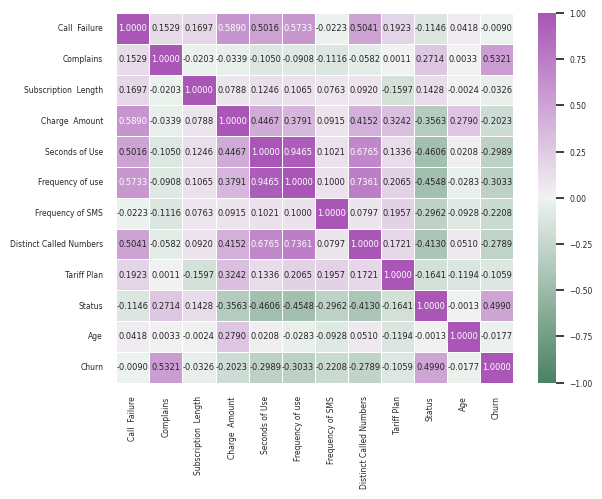

In [68]:

# calculate correlation
df_corr = df.corr()

import seaborn as sns
#plot heatmap correlation matrix
sns.set(font_scale=0.5)
#plt.figure(figsize=(16,12))
sns.heatmap(df_corr,
            annot=True,
            fmt=".4f",
            vmin=-1,
            vmax=1, 
            linewidths=.5, 
            cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True))

#plt.yticks(rotation=0)
#plt.show()

### Split the data

In [61]:
# Create arrays for the features and the target variable
X = df.drop('Churn', axis=1).values
y = df['Churn'].values

#import tools to split data into train/test
from sklearn.model_selection import train_test_split

#split data
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y,random_state=2023)

In [62]:
#import the classifier
from sklearn.neighbors import KNeighborsClassifier

#initialize the model
knn= KNeighborsClassifier(n_neighbors=5)

#fit the model
knn.fit(X_train,y_train)

#score
knn.score(X_test,y_test)


0.8428571428571429